In [2]:
from shapely import Point
import ee
import datetime
import plotly.graph_objects as go
import math
import numpy as np
import pandas as pd
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Input
from keras.layers import SimpleRNN, Bidirectional
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
coordinates = np.array([ 23.5544698, 40.025684])
x = float(coordinates[0])
y = float(coordinates[1])

scale = 11132
date_start = '2014-01-01'
date_end = '2018-01-01'

variables=['mean_2m_air_temperature']

location_point = ee.Geometry.Point(x, y)
gre= ee.ImageCollection('ECMWF/ERA5/DAILY').select(variables).filter(ee.Filter.date(date_start, date_end))
data= gre.getRegion(location_point, scale).getInfo()
data=pd.DataFrame(data,columns=data[0])
data = data.drop(0, axis=0)

data['mean_2m_air_temperature']=data['mean_2m_air_temperature'].astype('float')
data['mean_2m_air_temperature']=data['mean_2m_air_temperature'].apply(lambda x: x-273)
data['date'] = pd.to_datetime(data['id'], format='%Y%m%d')
data.set_index("date", inplace=True)
data.head()

,id,longitude,latitude,time,mean_2m_air_temperature
date,,,,,
2014-01-01,20140101,23.550108,40.050183,1388534400000,7.522064
2014-01-02,20140102,23.550108,40.050183,1388620800000,8.618561
2014-01-03,20140103,23.550108,40.050183,1388707200000,7.655518
2014-01-04,20140104,23.550108,40.050183,1388793600000,6.945709
2014-01-05,20140105,23.550108,40.050183,1388880000000,8.490448


In [5]:
data.shape

(1461, 5)

<Axes: xlabel='date'>

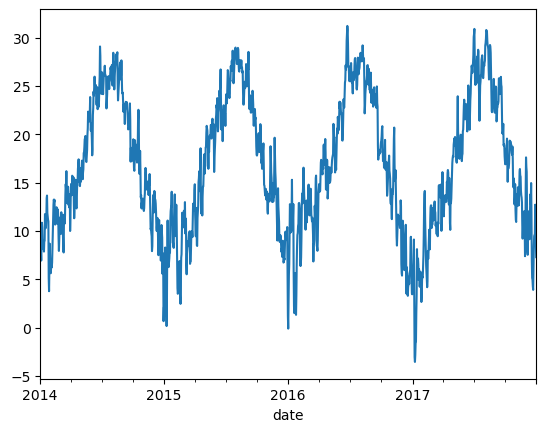

In [6]:
data.mean_2m_air_temperature.plot()

# Class for RNN

In [69]:
class RNNWeatherModel:
    
    def __init__(self, data, time_steps=50, units=50, use_bidirectional=True):
        """
        Initialize the RNNWeatherModel class.

        Parameters:
        - data: pd.DataFrame
            The dataset with weather information.
        - time_steps: int, optional
            Number of time steps for sequence generation. Default is 50.
        - units: int, optional
            Number of units (neurons) in each SimpleRNN layer. Default is 50.
        """
        self.data = data
        self.time_steps = time_steps
        self.units = units
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.use_bidirectional = use_bidirectional
    
    def preprocess_data(self):
        """
        Preprocess the dataset by splitting into train and test sets, scaling, and reshaping.
        """
        # Setting 80 percent data for training
        training_data_len = math.ceil(len(self.data) * .8)

        # Splitting the dataset
        self.train_data = self.data[:training_data_len].iloc[:, -1]
        self.test_data = self.data[training_data_len:].iloc[:, -1]

        # Reshape train and test data into 2D arrays
        dataset_train = np.reshape(self.train_data.values, (-1, 1))
        dataset_test = np.reshape(self.test_data.values, (-1, 1))

        # Scale the data
        scaled_train = self.scaler.fit_transform(dataset_train)
        scaled_test = self.scaler.transform(dataset_test)

        # Create the training sequences
        X_train, y_train = self.create_sequences(scaled_train)
        X_test, y_test = self.create_sequences(scaled_test)

        # Reshape input data into 3D shape (samples, time_steps, 1)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        y_train = np.reshape(y_train, (y_train.shape[0], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_test = np.reshape(y_test, (y_test.shape[0], 1))

        return X_train, y_train, X_test, y_test

    def create_sequences(self, scaled_data):
        """
        Create sequences of data for RNN training.

        Parameters:
        - scaled_data: np.array
            The scaled dataset.

        Returns:
        - X: np.array
            Input features for training or testing.
        - y: np.array
            Target output for training or testing.
        """
        X, y = [], []
        for i in range(self.time_steps, len(scaled_data)):
            X.append(scaled_data[i - self.time_steps:i, 0])
            y.append(scaled_data[i, 0])

        return np.array(X), np.array(y)


    def get_rnn_layer(self, return_sequences=True):
        if self.use_bidirectional:
            return Bidirectional(SimpleRNN(units=self.units, activation='tanh', return_sequences=return_sequences))
        else:
            return SimpleRNN(units=self.units, activation='tanh', return_sequences=return_sequences)


    def create_rnn_model(self, X_train_shape):
        """
        Create a Recurrent Neural Network (RNN) model.

        Parameters:
        - X_train_shape: tuple
            Shape of the training data features (time_steps, features).

        Returns:
        - regressor: Keras Sequential model
            The created RNN model.
        """
        regressor = Sequential()
        regressor.add(Input(shape=(X_train_shape[0], X_train_shape[1])))

        # Adding RNN layers and dropout regularization
        regressor.add(self.get_rnn_layer(return_sequences=True))
        regressor.add(Dropout(0.2))

        regressor.add(self.get_rnn_layer(return_sequences=True))
        regressor.add(Dropout(0.2))

        regressor.add(self.get_rnn_layer(return_sequences=True))
        regressor.add(Dropout(0.2))

        regressor.add(SimpleRNN(units=self.units))
        regressor.add(Dropout(0.2))

        # Adding the output layer
        regressor.add(Dense(units=1, activation='sigmoid'))

        return regressor
       

# Usage

In [ ]:
def train_rnn_model(data, time_steps=50, units=100, epochs=20, batch_size=32, optimizer='adam', use_bidirectional=False):
    # Create an instance of RNNWeatherModel
    rnn_model = RNNWeatherModel(data, time_steps=time_steps, units=units)

    # Preprocess the data
    X_train, y_train, X_test, y_test = rnn_model.preprocess_data()

    # Create the RNN model
    model = rnn_model.create_rnn_model(X_train.shape[1:])

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    # Model prediction
    y_RNN = model.predict(X_test)
    
    # Transform the predictions back using the scaler (assuming inverse_transform exists)
    y_RNN_transformed = rnn_model.scaler.inverse_transform(y_RNN)
        
    return model, y_RNN_transformed, history

model_no_bidir, y_RNN_no_bidir, history_no_bidir = train_rnn_model(data, time_steps=50, units=100, epochs=20, batch_size=32, optimizer='adam', use_bidirectional=False)
model_bidir, y_RNN_bidir, histor_bidir = train_rnn_model(data, time_steps=50, units=100, epochs=20, batch_size=32, optimizer='adam', use_bidirectional=True)

In [72]:
model_no_bidir.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_15 (Bidirectional)     │ (None, 50, 200)             │          20,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 50, 200)             │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 50, 200)             │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_23 (SimpleRNN)            │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,005 (1.96 MB)

 Trainable params: 171,001 (667.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 342,004 (1.30 MB)

In [73]:
model_bidir.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_18 (Bidirectional)     │ (None, 50, 200)             │          20,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 50, 200)             │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 50, 200)             │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,005 (1.96 MB)

 Trainable params: 171,001 (667.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 342,004 (1.30 MB)

# Ploting

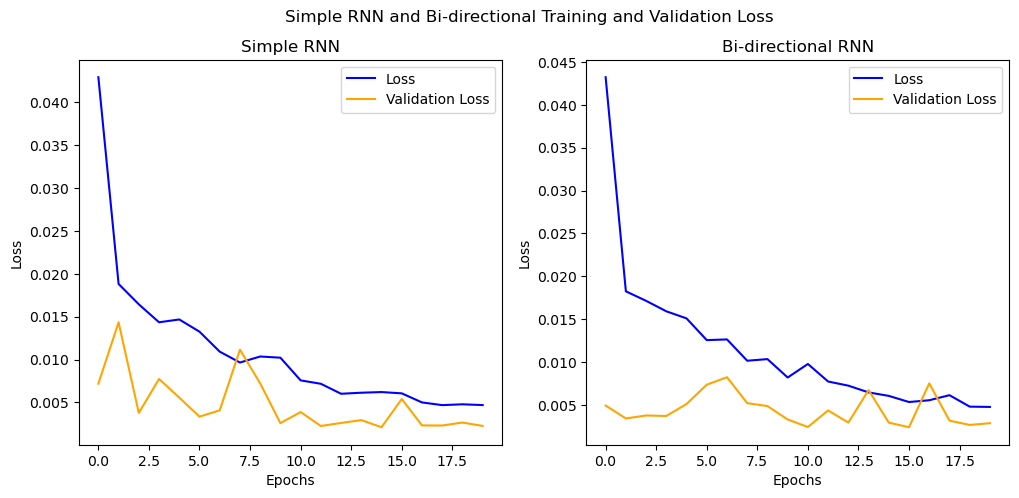

In [78]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the training loss on the first subplot
ax[0].plot(history_no_bidir.history['loss'], label='Loss', color='blue')
ax[0].plot(history_no_bidir.history['val_loss'], label='Validation Loss', color='orange')
ax[0].set_title('Simple RNN')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the validation loss on the second subplot
ax[1].plot(histor_bidir.history['loss'], label='Loss', color='blue')
ax[1].plot(histor_bidir.history['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Bi-directional RNN')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Display the subplots
plt.suptitle('Simple RNN and Bi-directional Training and Validation Loss')
plt.show()

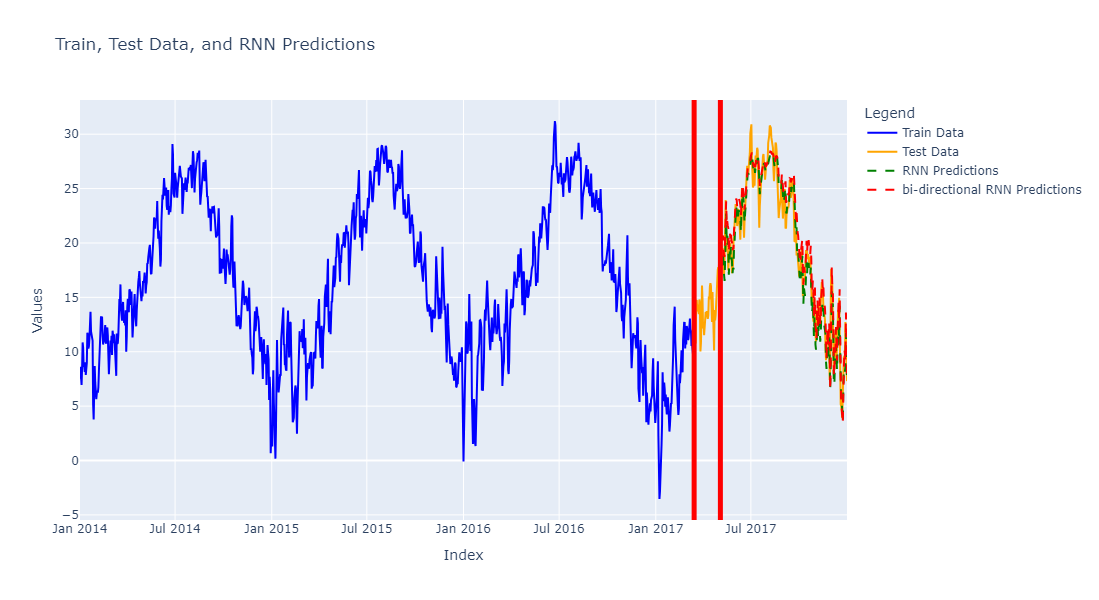

In [95]:
# Create the figure
fig = go.Figure()

# Add train data
fig.add_trace(go.Scatter(
    x=rnn_model.train_data.index,
    y=rnn_model.train_data.values.flatten(),  # Adjust based on your data shape
    mode='lines',
    name='Train Data',
    line=dict(color='blue')
))

# Add test data
fig.add_trace(go.Scatter(
    x=rnn_model.test_data.index,
    y=rnn_model.test_data.values.flatten(),  # Adjust based on your data shape
    mode='lines',
    name='Test Data',
    line=dict(color='orange')
))

# Add Simple RNN predictions
fig.add_trace(go.Scatter(
    x=rnn_model.test_data.index[50:],
    y=y_RNN_no_bidir.flatten(),  # Adjust based on your data shape
    mode='lines',
    name='RNN Predictions',
    line=dict(color='green', dash='dash')
))

# Add RNN bi-directional predictions
fig.add_trace(go.Scatter(
    x=rnn_model.test_data.index[50:],
    y=y_RNN_bidir.flatten(),  # Adjust based on your data shape
    mode='lines',
    name='bi-directional RNN Predictions',
    line=dict(color='red', dash='dash')
))

fig.add_vline(x=rnn_model.test_data.index[50], line_width=5, line_color="red")
fig.add_vline(x=rnn_model.test_data.index[0], line_width=5, line_color="red")

# Update layout
fig.update_layout(
    title='Train, Test Data, and RNN Predictions',
    xaxis_title='Index',
    yaxis_title='Values',
    legend_title='Legend',
    template='plotly',
    width=1100,  # Set the width of the plot
    height=600,  # Set the height of the plot
)


# Show the figure
fig.show()